In [1]:
!pip install -U scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 18.2 MB/s eta 0:00:00


In [2]:
pip install phik lightgbm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.6 MB/s eta 0:00:00


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Цель работы:** построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работы:**
- [X]  Загрузить данные
- [X]  Выполнить предобработку данных
- [X]  Выполнить подготовку данных для обучения моделей
- [X]  Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг
- [X]  Проанализировать время обучения, время предсказания и качество моделей
- [X]  Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке
- [X]  Сделать общий вывод

## Загрузка данных данных

In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import os

from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
way = '/content/autos.csv'

if os.path.exists(way):
    df = pd.read_csv(way)
else:
    print('Something is wrong')

In [7]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Вывод по первому шагу:** загрузили данные об автомобилях.

Представленный датафрейм состоит из 354369 строк и 16 столбцов, 7 из которых имеют тип int64, 9 - object. Сразу в глаза бросаются пропуски в колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`. Далее перейдем к поиску дубликатов, заполнению пропусков, поиску и устранению аномалий в данных.

## Предобработка данных

Оптимизируем размер датафрейма, изменив разрядность `int` с 64 до 32.

In [8]:
for column in df.columns:
    if df[column].dtype == 'int64':
        df[column] = df[column].astype('int32')

In [9]:
df.memory_usage(index=True).sum() / 1000000

35.437028

Данный шаг позволил уменьшить размер датафрейма примерно на 8 МБ.

Проанализируем пропуски.

In [10]:
df.isna().sum().to_frame().style.background_gradient('Reds')

,0
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


В некоторых столбцах имеется большое количество пропусков. Удаление строк с ними может отразиться на итоговом результате, поэтому выполним заполнение пропусков.

Пропуски в колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` заполним наиболее часто встречающимися значениями.

In [11]:
vehicle_mode = df['VehicleType'].mode().item()
df['VehicleType'] =df['VehicleType'].fillna(vehicle_mode)

gear_mode = df['Gearbox'].mode().item()
df['Gearbox'] =df['Gearbox'].fillna(gear_mode)

model_mode = df['Model'].mode().item()
df['Model'] =df['Model'].fillna(model_mode)

fuel_mode = df['FuelType'].mode().item()
df['FuelType'] =df['FuelType'].fillna(fuel_mode)

repaired_mode = df['Repaired'].mode().item()
df['Repaired'] =df['Repaired'].fillna(repaired_mode)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int32 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int32 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int32 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int32 
 8   RegistrationMonth  354369 non-null  int32 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int32 
 14  PostalCode         354369 non-null  int32 
 15  LastSeen           354369 non-null  object
dtypes: int32(7), object(

Проверим данные на наличие явных дубликатов.

In [13]:
df.duplicated().sum()

5

Обнаружили 5 дубликатов, избавимся от них.

In [14]:
df = df.drop_duplicates()

Рассмотрим числовые признаки на предмет аномалий.

In [15]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


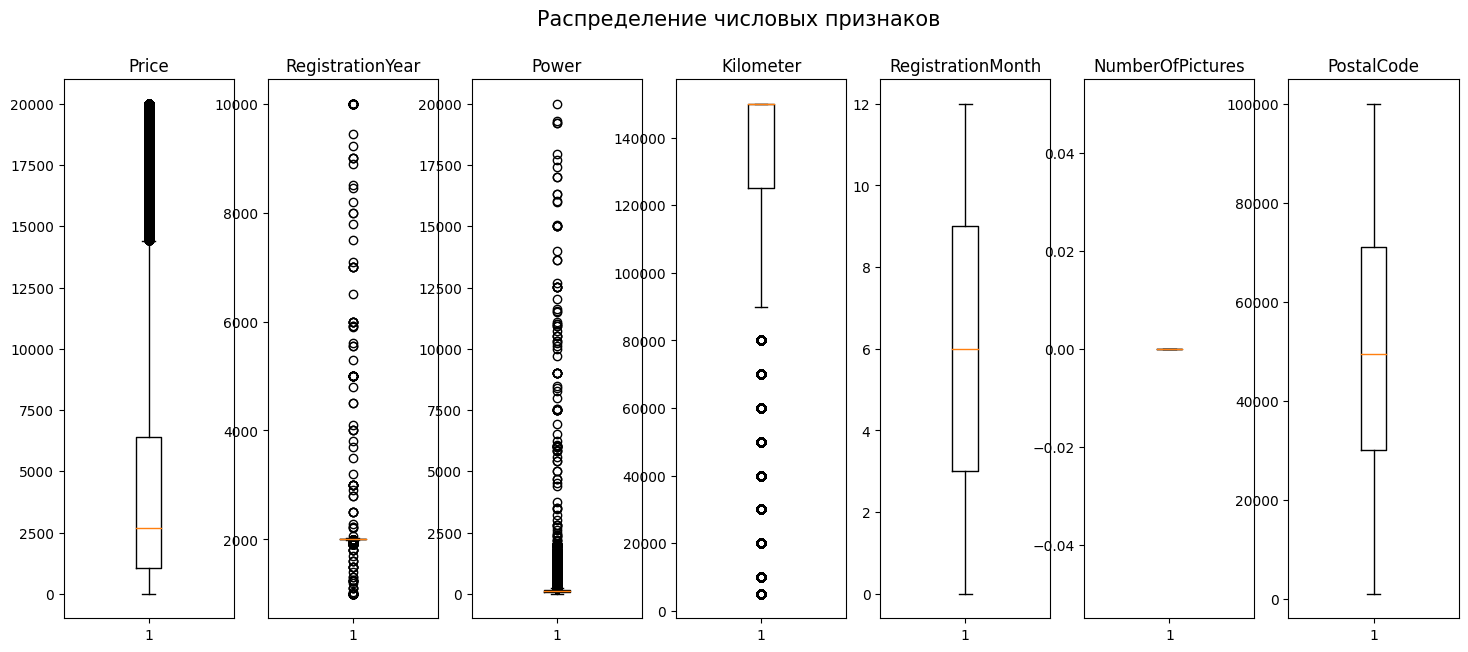

In [16]:
num_cols = df.select_dtypes(include='int32').columns.tolist()
fig, axs = plt.subplots(1, 7)
ax = axs.ravel()
plt.figure
fig.suptitle('Распределение числовых признаков', fontsize=15)
fig.set_size_inches(18, 7)
for i, num in enumerate(num_cols):
    ax[i].boxplot(df[num])
    ax[i].set_title(num)
plt.show()

Избавимся от данных с годом регистрации больше, чем *максимальный год выгрузки данных из базы* и меньше 1900, мощностью более 1600 л.с.(т.к. это максимальная, зафиксированная на данный момент) и менее 10 л.с.(автомобили мощностью чуть больше 10 л.с. всё же существуют), пробегом менее 90000 км.

Столбец с количеством фотографий является неинформативным, избавимся от него полностью. Возможно, произошла ошибка при сборе данных. Столбцы с почтовым кодом и месяцем постановки автомобиля на учёт не должны влиять на ценообразование, так же исключим их.

In [17]:
# Найдем максимальный год выгрузки данных из базы
max_year = pd.DatetimeIndex(df['DateCrawled']).year.max()

In [18]:
df = df.query('(RegistrationYear < @max_year) & (RegistrationYear > 1900) & (Power <= 1600) & (Power > 10) & (Price > 1000)')

In [19]:
df = df.drop(['NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1)

**Вывод по второму шагу:** уменьшили датафрейм на 8 Мб путем изменения разрядности данных типа `int`. Обнаружили пропуски в колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, избавились от них, заполнив наиболее часто встречающимися значениями. После убрали найденные явные дубликаты. Далее провели анализ на предмет аномалий и выбросов и сотавили значения, удовлетворяющие условиям: год регистрации в границах 1900 - 2016, мощность от 10 л.с. до 1600 л.с.(т.к. это максимальная, зафиксированная на данный момент), цена более 1000 евро. Столбцы с количеством фотографий, месяцем постановки на учет, почтовым кодом являются неинформативными, избавились от них.

## Подготовка данных для обучения моделей

In [20]:
df[['DateCrawled', 'LastSeen', 'DateCreated']].nunique()

,0
DateCrawled,196471
LastSeen,124399
DateCreated,103


Столбцы `DateCrawled`, `LastSeen` имеют большое количество уникальных значений, что сильно усложнит обучение. При этом они, очевидно, не окажут большого влияние при подсчете целевого признака, как и `DateCreated`. Исключим их.

In [21]:
df = df.drop(['DateCrawled', 'LastSeen', 'DateCreated'], axis=1)

Посмотрим, как признаки коррелируют между собой.

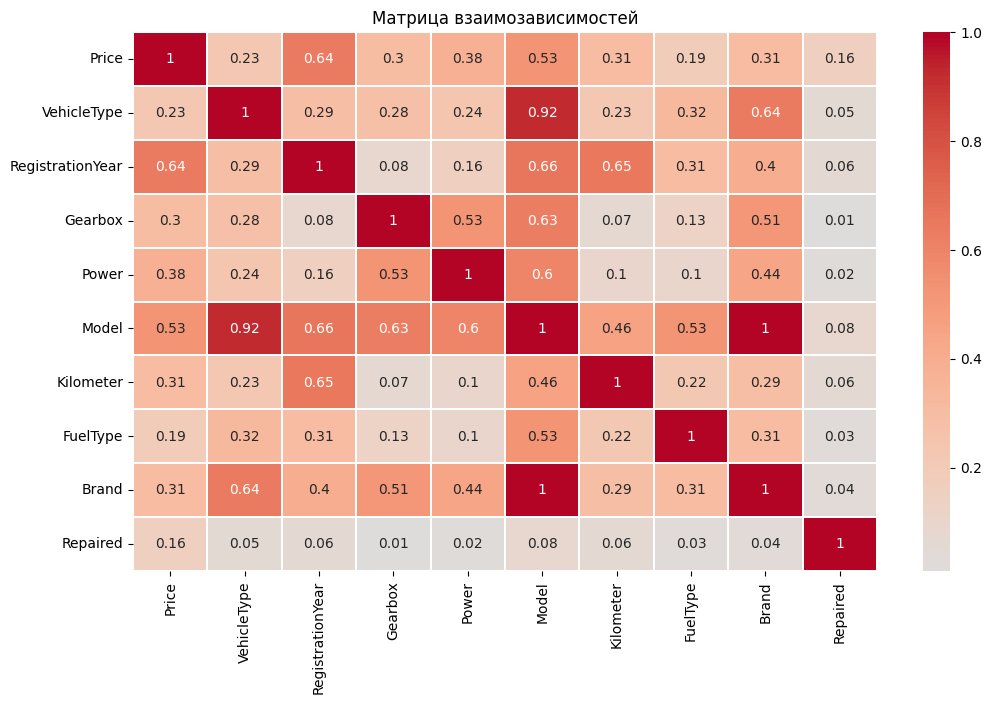

In [22]:
phik_overview = df.phik_matrix(interval_cols=['Price', 'Power'])
plt.figure(figsize=(12, 7))
corr_matrix = phik_overview
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidth= 0.3, cmap='coolwarm', center=0)
plt.title('Матрица взаимозависимостей')
plt.show()

Столбец `Model` имеет высокую степень корреляции со столбцами `VehicleType` и `Brand`, что похоже на мультиколлениарность. Но т.к. мультиколлинеарность не страшна для нелинейных моделей, которые составляют основу нашего исследования, удалять данный признак не будем.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234483 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             234483 non-null  int32 
 1   VehicleType       234483 non-null  object
 2   RegistrationYear  234483 non-null  int32 
 3   Gearbox           234483 non-null  object
 4   Power             234483 non-null  int32 
 5   Model             234483 non-null  object
 6   Kilometer         234483 non-null  int32 
 7   FuelType          234483 non-null  object
 8   Brand             234483 non-null  object
 9   Repaired          234483 non-null  object
dtypes: int32(4), object(6)
memory usage: 16.1+ MB


После чего разделим данные на обучающую и тестовую части.

In [24]:
features = df.drop('Price', axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=99)

Выделим числовые и категориальные признаки для кодирования.

In [25]:
cat_features = ['VehicleType',
                'RegistrationYear',
                'Gearbox',
                'Model',
                'Kilometer',
                'FuelType',
                'Brand',
                'Repaired']
num_features = 'Power'

Выполним масштабирование непрерывных переменных.

In [26]:
scaler = StandardScaler()

In [27]:
scaler.fit(pd.DataFrame(features_train[num_features]))
features_train_num = pd.DataFrame(scaler.transform(pd.DataFrame(features_train[num_features])))
features_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(features_test[num_features])))

In [28]:
features_train_num.columns = scaler.get_feature_names_out()
features_test_num.columns = scaler.get_feature_names_out()

In [29]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

In [30]:
encoder.fit(features_train[cat_features])
features_train_categorical = pd.DataFrame(encoder.transform(features_train[cat_features]).toarray())
features_test_categorical = pd.DataFrame(encoder.transform(features_test[cat_features]).toarray())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
features_train_categorical.columns = encoder.get_feature_names_out()
features_test_categorical.columns = encoder.get_feature_names_out()

In [32]:
features_train = pd.concat([features_train_num.reset_index(drop=True), features_train_categorical.reset_index(drop=True)], axis=1)
features_test = pd.concat([features_test_num.reset_index(drop=True), features_test_categorical.reset_index(drop=True)], axis=1)

**Вывод по третьему шагу:** исключили столбцы `DateCrawled` и `LastSeen`, т.к. они имеют большое количество уникальных значений, что сильно усложнит обучение, и ,к тому же, не окажут большого влияние при подсчете целевого признака.

Подготовили выборки для обучения и тестирования моделей.

## Анализ моделей

Рассмотрим несколько моделей. Данные сведем в одну таблицу.

In [33]:
result = {'RMSE':[], 'fit_time':[], 'prediction_time':[]}

In [34]:
def result_append(model_gs, ft, pt):
    result['RMSE'].append(model_gs.best_score_)
    result['fit_time'].append(ft)
    result['prediction_time'].append(pt)

### Дерево решений

Обучим модель подберем гиперпараметры при помощи GridSearchCV и оценим значение метрики RMSE.

In [35]:
tree = DecisionTreeRegressor(random_state=99, max_depth=7)

In [36]:
parametrs = ({'max_depth':range(4, 9)
             })

In [37]:
tree_gs = GridSearchCV(tree, parametrs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

In [38]:
tree_gs.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeRegressor(max_depth=7, random_state=99),
             n_jobs=-1, param_grid={'max_depth': range(4, 9)},
             scoring='neg_root_mean_squared_error')

In [39]:
model = tree_gs.best_estimator_

In [40]:
start = time()

model.fit(features_train, target_train)

end = time()

fit_time = (end-start)/60

In [41]:
start = time()

model.predict(features_train)

end = time()

predict_time = (end-start)/60

In [44]:
result_append(tree_gs, fit_time, predict_time)

### Ridge

Обучим модель, пайплайн для нее, подберем гиперпараметры при помощи GridSearchCV и оценим значение метрики RMSE.

In [45]:
linear = Ridge()

In [46]:
lin_parametrs = ({'alpha':[0.01, 0.1, 0.5, 1]})

In [47]:
linear_gs = GridSearchCV(linear, lin_parametrs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

In [48]:
linear_gs.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1]},
             scoring='neg_root_mean_squared_error')

In [49]:
model = linear_gs.best_estimator_

In [50]:
start = time()

model.fit(features_train, target_train)

end = time()

fit_time = (end-start)/60

In [51]:
start = time()

model.predict(features_train)

end = time()

predict_time = (end-start)/60

In [52]:
result_append(linear_gs, fit_time, predict_time)

### LightGBM

In [53]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        random_state=99)

In [54]:
param_grid = {
    'learning_rate': [0.01, 0.5],
    'n_estimators': [35, 40]
}

In [55]:
gbm_gs = GridSearchCV(gbm, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

In [56]:
gbm_gs.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 187586, number of used features: 347
[LightGBM] [Info] Start training from score 5926.053543


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=99), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.5],
                         'n_estimators': [35, 40]},
             scoring='neg_root_mean_squared_error')

In [57]:
model = gbm_gs.best_estimator_

In [58]:
start = time()

model.fit(features_train, target_train)

end = time()

fit_time = (end-start)/60

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 187586, number of used features: 347
[LightGBM] [Info] Start training from score 5926.053543


In [59]:
start = time()

model.predict(features_train)

end = time()

predict_time = (end-start)/60

In [60]:
result_append(gbm_gs, fit_time, predict_time)

In [61]:
pd.DataFrame(result,index=['DesicionTree', 'Ridge', 'LightGBM'])

,RMSE,fit_time,prediction_time
DesicionTree,-2748.124535,0.067178,0.006650
Ridge,-2178.809689,0.030599,0.006564
LightGBM,-1798.082913,0.037889,0.023796


**Вывод по третьему шагу:** обучили три модели: LightGBM, линейную регрессию и дерево решений. Лучшее значение метрики `RMSE` показала модель LightGBM, при этом её время обучения соизмеримо с деревом решений и линейной регрессией. Время предсказания больше в 4 раза. По соотношению времени и качества лучше всего себя показал градиентный бустинг. Поэтому для тестирования и продакшена выберем именно модель LightGBM.

## Тестирование модели

Выполним проверку модели градиентного бустинга на тестовой выборке.

In [62]:
gbm_test_pred = model.predict(features_test)

In [63]:
gbm_rmse_test = mean_squared_error(target_test, gbm_test_pred) ** 0.5
gbm_rmse_test

1766.9991010283507

Зададим константную модель и сравним получившийся результат.

In [64]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_pred = dummy_regr.predict(features_train)

In [65]:
dummy_rmse = mean_squared_error(target_train, dummy_pred) ** 0.5
dummy_rmse

4595.161479116956

**Вывод по пятому шагу:** качество модели на тестовой выборке близко к качеству на обучающей выборке, значит пере- или недо- обучения модели не произошло. При этом, если сравнивать получившийся результат с константной моделью, модель градиентного бустинга показывает результат практически в три раза лучше.

## Общий вывод

**Общий вывод:** загрузили данные об автомобилях.

Представленный датафрейм состоит из 354369 строк и 16 столбцов, 7 из которых имеют тип int64, 9 - object.

Уменьшили датафрейм на 8 Мб путем изменения разрядности данных типа `int`. Обнаружили пропуски в колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, избавились от них, заполнив наиболее часто встречающимися значениями. После убрали найденные явные дубликаты. Далее провели анализ на предмет аномалий и выбросов и сотавили значения, удовлетворяющие условиям: год регистрации в границах 1900 - 2016, мощность от 10 л.с. до 1600 л.с.(т.к. это максимальная, зафиксированная на данный момент), цена более 1000 евро. Столбцы с количеством фотографий, месяцем постановки на учет, почтовым кодом являются неинформативными, избавились от них.

Исключили столбцы `DateCrawled` и `LastSeen`, т.к. они имеют большое количество уникальных значений, что сильно усложнит обучение, и, к тому же, не окажут большого влияние при подсчете целевого признака.

Подготовили выборки для обучения и тестирования моделей.

Обучили три модели: LightGBM, линейную регрессию и дерево решений. Лучшее значение метрики `RMSE` показала модель LightGBM, при этом её время обучения соизмеримо с деревом решений и линейной регрессией. Время предсказания больше в 4 раза. По соотношению времени и качества лучше всего себя показал градиентный бустинг. Поэтому для тестирования и продакшена выберем именно модель LightGBM.

Качество модели на тестовой выборке близко к качеству на обучающей выборке, значит пере- или недо- обучения модели не произошло. При этом, если сравнивать получившийся результат с константной моделью, модель градиентного бустинга показывает результат практически в три раза лучше.